In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import scipy.stats as sps

In [2]:
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

**Задачи**:
* Вычислить суммарную экспрессию изоформ с мутациями на 5' для каждой микроРНК;
* Определить максимальную экспрессию среди 5'-изоформ для каждой микроРНК;
* Определить суммарную экспрессию для данной микроРНК. Из нее можно получить экспрессию канонических микроРНК.

In [3]:
def path(name, type_):
    return "~ksuma/isomirs/" + name + "_isomir/output-IsoMiRmap_v5-"+type_+"-isomiRs.expression.txt"

def get_table(name, type_, dig):
    ''' Reading the file '''
    df = pd.read_fwf(path(name, type_), delimiter = '/t')
    df = df['## Table of '+type_+'-isomiRs.'].str.split('\t', expand = True)
    df.columns = df.loc[dig]
    
    ''' Deleting tandem repeats (in case of exclusive it is not neccessary)'''
    df = df.where(df[df.columns[-1]] == '').dropna()
    df = df.rename(columns = {df.columns[-1] :'Repeated'})
    df = df.rename(columns = {'Mature meta-data (bracket delimited per hairpin)' :'Mature'})
    
    df.index = 1 + np.arange(0, len(df))
    df['RPM '+name] = pd.to_numeric(df['RPM**'])
    return df[['IsomiR sequence', 'RPM ' + name, 'Mature']]

def get_type(name, table, typ):
    table[name+' type'] = [typ if table['RPM '+name].loc[i] else 0 for i in range(table.shape[0])]
    return table

In [4]:
# определяем референсную микроРНК (вытаскиваем название)
def refer(x):
    try:
        x = x.split('&')[1]
        if 'hsa-' in x:
            return x
    except:
        pass

In [5]:
# вытаскиваем название изоформ
def mir(x):
    try:
        for i in x.split('], ['):
            i = i.strip('[]').split(', ')[0]
            i = re.sub(r'&offsets','', i)
            k = i.split('&')[1]
        if 'hsa-' in k:
            return k
    except:
        pass

In [6]:
def find_5_isomiRs(name):
    factor = get_table(name, "exclusive", 5)
    
    # вытаскиваем название изоформы микроРНК
    factor['isomiR'] = factor['Mature'].apply(mir)

    # Определяем референс
    factor['Mature'] = factor['Mature'].apply(refer)
    factor = factor.dropna()

    # определяем 5'-изоформы (добавляем бинарный столбец: 1 - 5'-isomiR; 0 - каноническая)
    factor['binary_5'] = factor['isomiR'].apply(lambda i: 0 if '|0|' in i else 1)
    
    # определяем, какая экспрессия для 5'-изоформ, принадлежащих одной микроРНК
    expression_5 = factor.loc[factor['binary_5'] == 1].groupby("Mature").sum()['RPM '+name]

    # суммарная экспрессия
    expression_all = factor.groupby("Mature").sum()['RPM '+name]

    # ищем макс экспрессию среди 5'-изоформ
    max_expression_5 = factor.loc[factor['binary_5'] == 1].groupby("Mature").max()['RPM '+name]
    
    table = pd.DataFrame([max_expression_5, expression_5, expression_all],
             index = ["max 5'-isomiR expr", "sum 5'-isomiR expr", 'total']).T
    table = table.fillna(0)
    
    table = pd.DataFrame([table.index, table["max 5'-isomiR expr"], 
                     table["sum 5'-isomiR expr"], table["total"]],
                     index = ['Mature'] + list(table.columns)).T
    return table

In [7]:
ELOV5 = find_5_isomiRs("ELOV5")
LUC = find_5_isomiRs("LUC")
IGFBP6 = find_5_isomiRs("IGFBP6")

In [8]:
ELOV5.sort_values(by = "max 5'-isomiR expr", ascending = False).head(5)

,Mature,max 5'-isomiR expr,sum 5'-isomiR expr,total
159,hsa-miR-29a-3p,646.23,921.38,2440.51
31,hsa-miR-10a-5p,149.5,306.36,897.78
234,hsa-miR-423-3p,117.5,234.15,1776.97
61,hsa-miR-1307-3p,86.54,188.33,824.25
72,hsa-miR-140-3p,52.95,180.85,275.28


In [9]:
LUC.sort_values(by = "max 5'-isomiR expr", ascending = False).head()

,Mature,max 5'-isomiR expr,sum 5'-isomiR expr,total
203,hsa-miR-29a-3p,559.6,804.16,1890.64
34,hsa-miR-10a-5p,170.7,325.84,942.6
318,hsa-miR-423-3p,105.67,221.02,1595.54
76,hsa-miR-1307-3p,93.65,193.16,806.11
89,hsa-miR-140-3p,52.49,182.87,278.39


In [10]:
IGFBP6.sort_values(by = "max 5'-isomiR expr", ascending = False).head()

,Mature,max 5'-isomiR expr,sum 5'-isomiR expr,total
196,hsa-miR-29a-3p,799.14,1125.96,2584.98
75,hsa-miR-1307-3p,155.75,326.98,1316.56
308,hsa-miR-423-3p,94.64,194.47,1382.12
37,hsa-miR-10a-5p,82.32,158.05,515.72
396,hsa-miR-504-5p,77.25,96.39,269.87


### Зависимость доли неканонических изоформ от типа трансдукции

In [17]:
IGFBP6_ = IGFBP6.loc[IGFBP6["sum 5'-isomiR expr"] > 0.5]
LUC_ = LUC.loc[LUC["sum 5'-isomiR expr"] > 0.5]
ELOV5_ = ELOV5.loc[ELOV5["sum 5'-isomiR expr"] > 0.5]

In [42]:
# ищем общие микрорнк
comm = IGFBP6_.loc[IGFBP6_['Mature'].isin(LUC_['Mature'])]
comm = comm.loc[comm['Mature'].isin(ELOV5_['Mature'])]['Mature']

ELOV5_ = ELOV5_.loc[ELOV5_['Mature'].isin(comm)]
LUC_ = LUC_.loc[LUC_['Mature'].isin(comm)]
IGFBP6_ = IGFBP6_.loc[IGFBP6_['Mature'].isin(comm)]

In [43]:
def diff(name):
    return 100 * name["sum 5'-isomiR expr"].astype('float') / name["total"].astype('float')

In [55]:
IGFBP6_['diff IGFBP6'] = diff(IGFBP6_)
LUC_['diff LUC'] = diff(LUC_)
ELOV5_['diff ELOV5'] = diff(ELOV5_)

In [89]:
names = list(set(IGFBP6_['Mature']) & set(ELOV5_['Mature']) & set(LUC_['Mature']))
luc_d = LUC_.loc[LUC_['Mature'].isin(names)]
igf_d = IGFBP6_.loc[IGFBP6_['Mature'].isin(names)]
elov5_d = ELOV5_.loc[ELOV5_['Mature'].isin(names)]

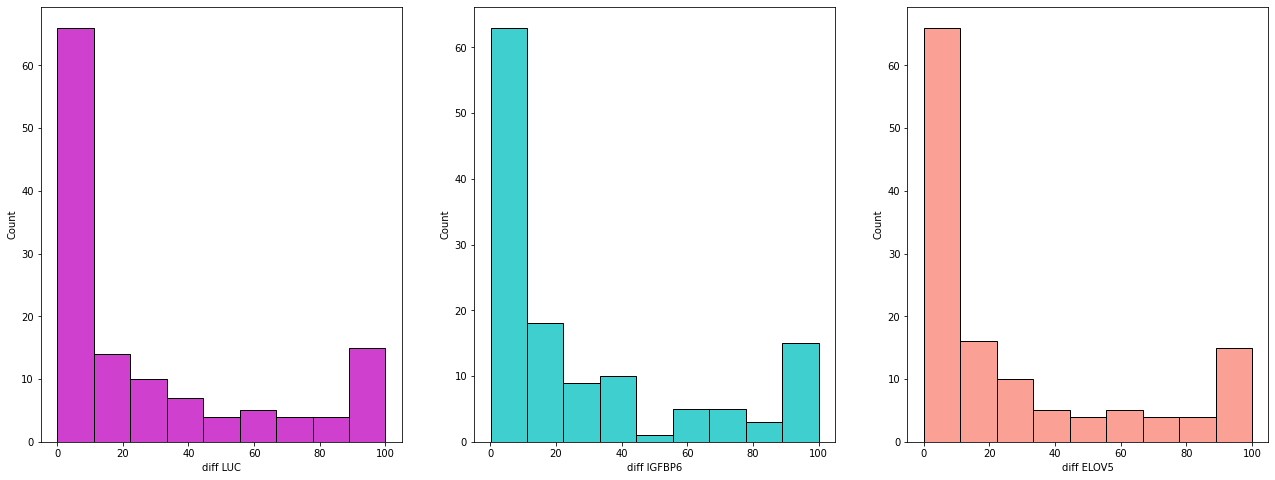

In [90]:
fig, axs = plt.subplots(1, 3, figsize = (22, 8))

sns.histplot(data = luc_d, x = 'diff LUC', color = 'm', ax = axs[0])
sns.histplot(data = igf_d, x = 'diff IGFBP6', color = 'c', ax = axs[1])
sns.histplot(data = elov5_d, x = 'diff ELOV5', color = 'salmon', ax = axs[2])
plt.show()